# CLUSTERING TECHNIQUES

## USE OF DATASETS WITH GROUND TRUTH FOR COMPARING THE DIFFERENT TECHNIQUES

### FIRST DATASET - REUTERS NEWS - A BASELINE DATASET WITH ONLY TWO LABELS (GROUND TRUTH K=2)

In [1]:
import pandas as pd
import numpy as np
import spacy

#load the dataset
dataset_filepath = 'datasets/bbc_news_train.csv'
bbc_df = pd.read_csv(dataset_filepath)
bbc_cols = bbc_df.columns.to_list()
print(f'The length of the dataset is: {len(bbc_df)}')
print(bbc_cols)

The length of the dataset is: 1490
['ArticleId', 'Text', 'Category']


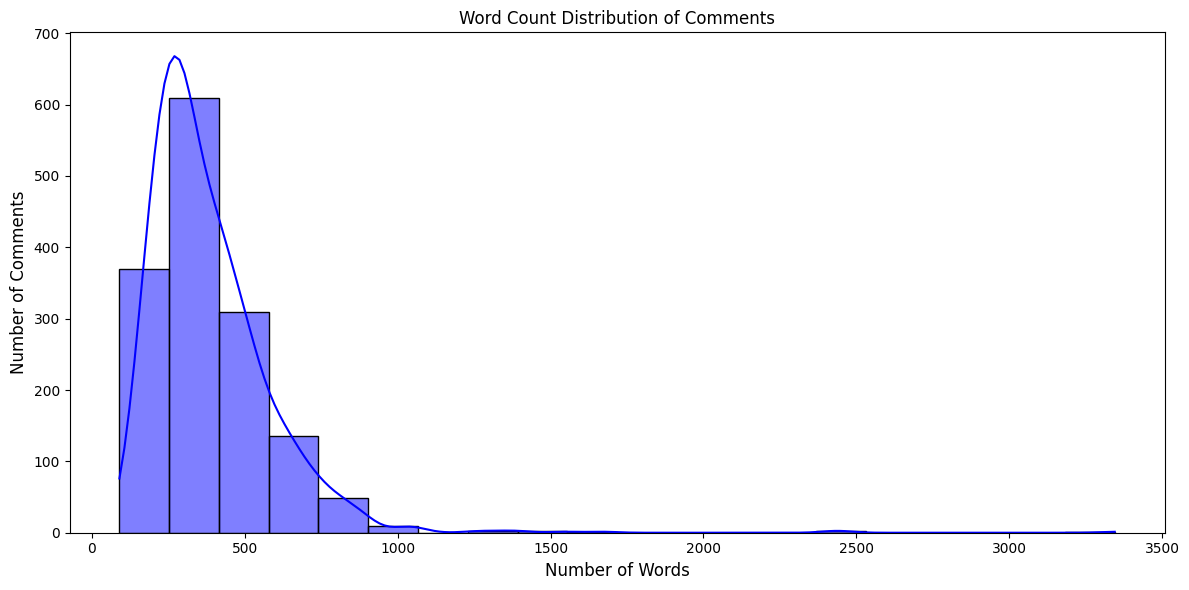

In [2]:
from utils.plot_words_distribution import plot_distribution_of_words
# rename some columns
bbc_df = bbc_df.rename(columns={
    'Category': 'topic', 
    'Text': 'review'
})

# define the column name of the text
text_col = 'review'
label_col='topic'

# plot the words distribution
plot_distribution_of_words(bbc_df, text_col)

In [3]:
# display the different topics
print(f'The topics of this dataset are: {bbc_df.topic.unique()}')
print(f'The number of topics is: {bbc_df.topic.nunique()}')

The topics of this dataset are: ['business' 'tech' 'politics' 'sport' 'entertainment']
The number of topics is: 5


### CREATE THE NECESSARY UTILS FOR PREPARING THE DATA

In [4]:
from sklearn.preprocessing import LabelEncoder
from utils.load_pretrained_spacy_model import load_pretrained_model
from sklearn.model_selection import train_test_split

x_train_bbc, x_test_bbc, y_train_bbc, y_test_bbc = train_test_split(
    bbc_df,
    bbc_df[label_col],
    test_size=0.1,
    random_state=42,
    stratify=bbc_df[label_col],
)

# load the pretrained spacy model
x_test_bbc, nlp_pretrained_name = load_pretrained_model(df=x_test_bbc, text_col=text_col)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Convert the string labels to integer labels
labels_bbc = label_encoder.fit_transform(y_test_bbc)

The language of the dataset is: en


### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn(


Sentences transformed successfully via TF-IDF vectorizer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.80it/s]

The optimum kappa based on Silhouette score is: 49


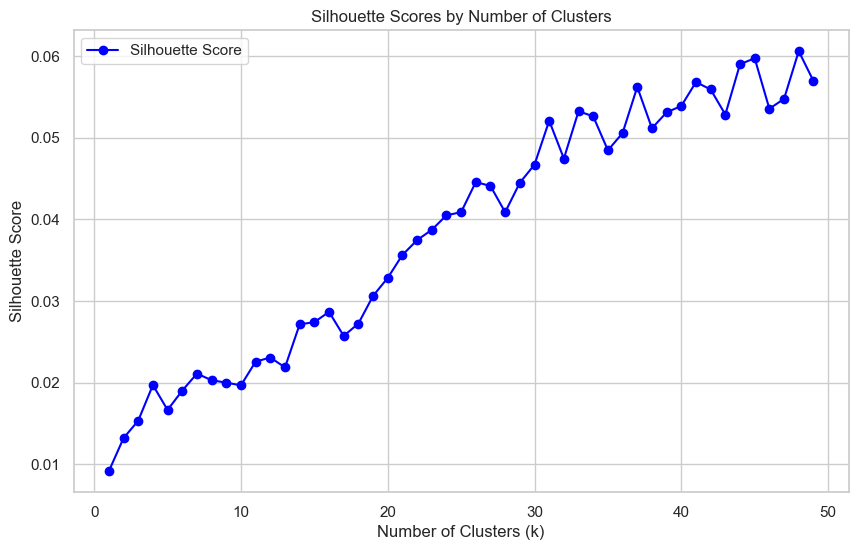

The NMI score is: 0.5461709136848903 for the best Kappa 49
The AMI score is: 0.3789853910020212 for the best Kappa 49
The ARI score is: 0.11601301952053897 for the best Kappa 49


In [5]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import calc_tf_idf_vectors

# define the spacy model
nlp = spacy.load(nlp_pretrained_name)

# define the corpus
corpus = bbc_df[text_col].to_list()

# calc TF-IDF features
transformed_data_tfidf = calc_tf_idf_vectors(corpus, x_test_bbc[text_col], nlp)

max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_tfidf, max_num_of_clusters, true_labels=labels_bbc)

#### USING FASTTEXT VECTORIZATION

Sentences transformed successfully via pretrained FastText language model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.87it/s]


The optimum kappa based on Silhouette score is: 2


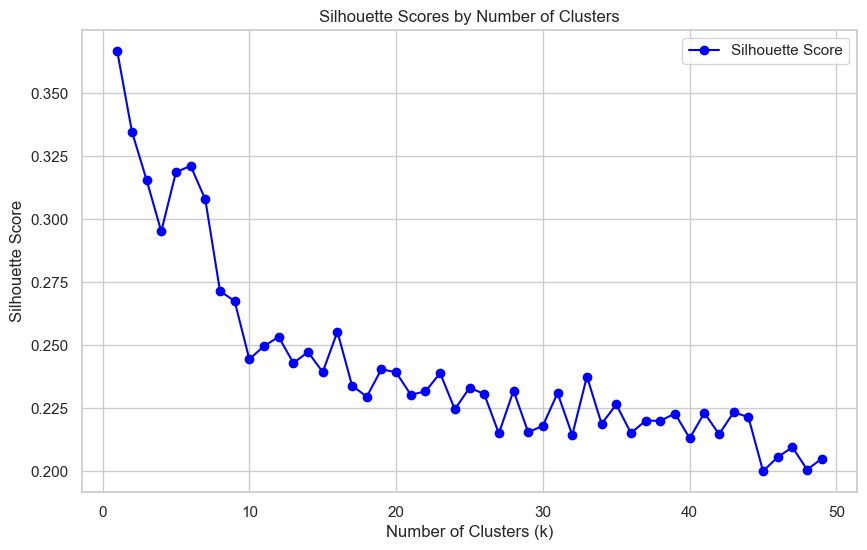

The NMI score is: 0.2808859230710873 for the best Kappa 2
The AMI score is: 0.26585215772564896 for the best Kappa 2
The ARI score is: 0.2241095024748185 for the best Kappa 2


In [6]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import train_fasttext_and_transform

# define the corpus
corpus = bbc_df[text_col].to_list()

transformed_data_fasttext = train_fasttext_and_transform(corpus, x_test_bbc[text_col].to_list(), text_col)

max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_fasttext, max_num_of_clusters, true_labels=labels_bbc)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.22it/s]


The optimum kappa based on Silhouette score is: 8


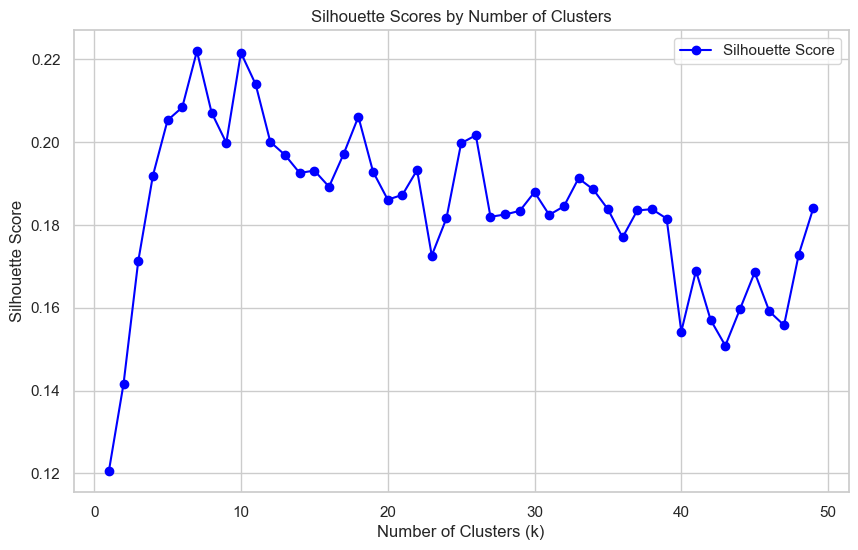

The NMI score is: 0.7455677897199275 for the best Kappa 8
The AMI score is: 0.7282282137259904 for the best Kappa 8
The ARI score is: 0.5951114623929735 for the best Kappa 8


In [10]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import calc_embeddings
from sklearn.decomposition import PCA

# transformed_data_embeddings = calc_embeddings(x_test_bbc[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=16) 
reduced_data = pca.fit_transform(transformed_data_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_tf, scores_kmeans_tf, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
   reduced_data, max_num_of_clusters, true_labels=labels_bbc)

#### USING OPENAI ADA TEXT EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.41it/s]


The optimum kappa based on Silhouette score is: 13


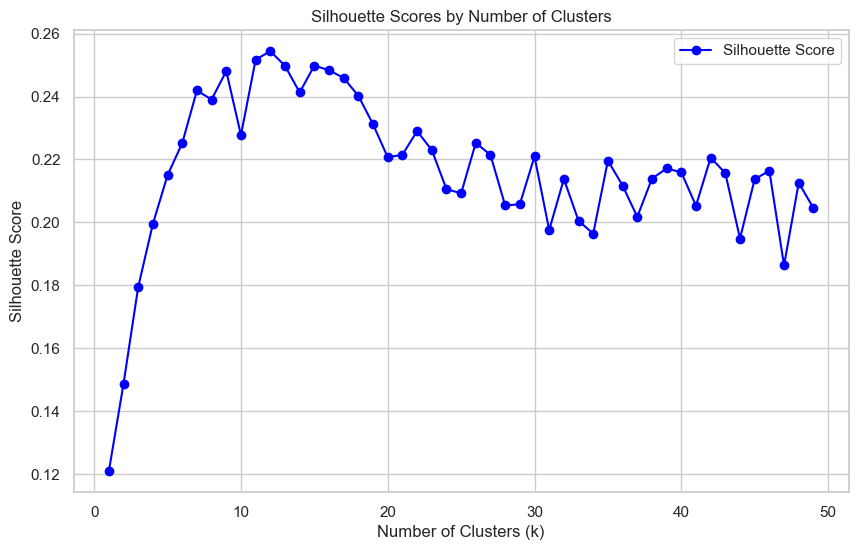

The NMI score is: 0.6798315064902356 for the best Kappa 13
The AMI score is: 0.6447514230823135 for the best Kappa 13
The ARI score is: 0.45348300822596854 for the best Kappa 13


In [9]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.GPT_Prompting import PromptingGPT
from sklearn.decomposition import PCA

# Create a new instance of GPT model in each iteration
gpt_embeddings = PromptingGPT()

# openai_ada_embeddings = gpt_embeddings.get_embeddings(texts=x_test_bbc[text_col], max_token_length=8000)

# Reduce the dimensionality of embeddings
pca = PCA(n_components=16) 
reduced_data = pca.fit_transform(openai_ada_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ada, scores_kmeans_ada, nmi_ada, ari_ada, ami_ada = calc_kmeans(
    reduced_data, max_num_of_clusters, true_labels=labels_bbc)

### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:09<00:00,  5.05it/s]

The optimum kappa based on Penalized Silhouette score is: 7


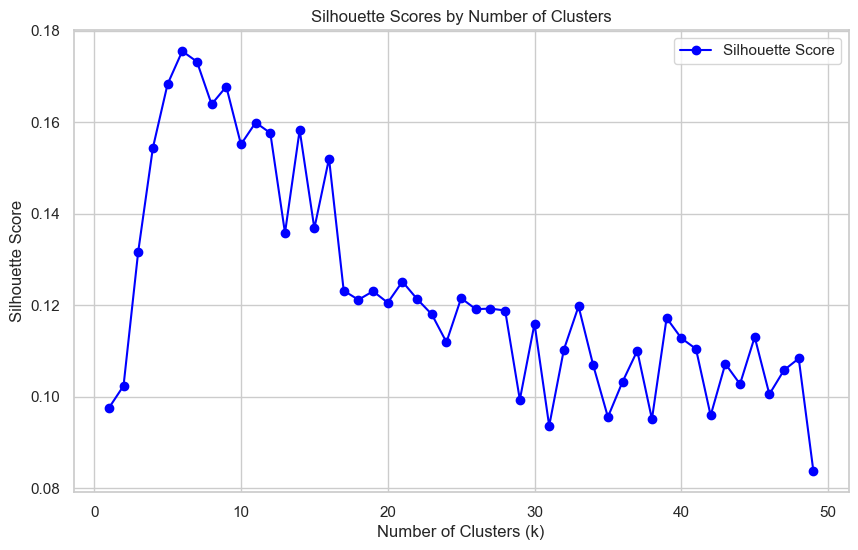

The NMI score is: 0.7678557715016513 for the best Kappa 7
The AMI score is: 0.7533669852520655 for the best Kappa 7
The ARI score is: 0.6866282579343326 for the best Kappa 7


In [9]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
from utils.text_to_embeddings import calc_embeddings
from sklearn.decomposition import PCA

# transformed_data_embeddings = calc_embeddings(x_test_bbc[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=16) 
reduced_data = pca.fit_transform(transformed_data_embeddings)
max_num_of_clusters = 50

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_tf, scores_kmeans_cv_tf, nmi_ada, ari_ada, ami_ada = get_number_of_clusters_with_statistic_constrained(
   reduced_data, max_num_of_clusters, true_labels=labels_bbc
)

#### USING OPENAI ADA TEXT EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:10<00:00,  4.66it/s]

The optimum kappa based on Penalized Silhouette score is: 11


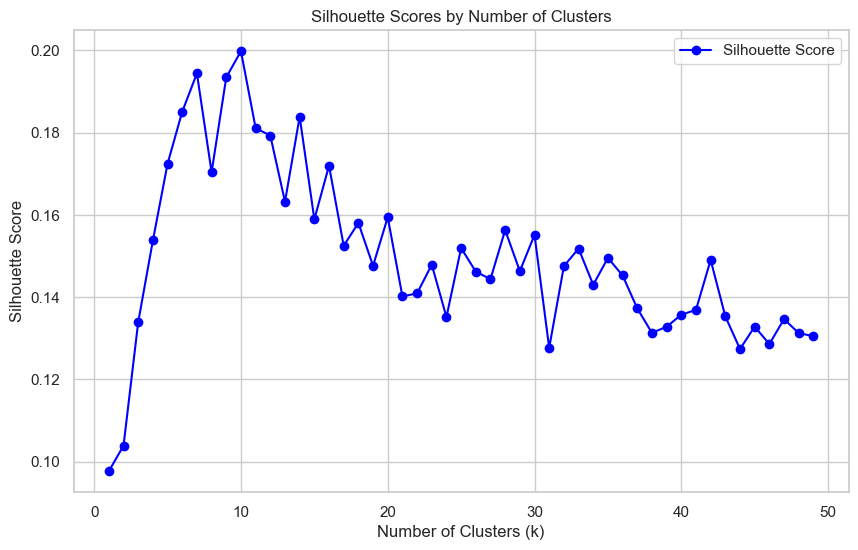

The NMI score is: 0.7000635787128089 for the best Kappa 11
The AMI score is: 0.6726063724982208 for the best Kappa 11
The ARI score is: 0.46500865294724997 for the best Kappa 11


In [10]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.GPT_Prompting import PromptingGPT
from sklearn.decomposition import PCA

# Create a new instance of GPT model in each iteration
gpt_embeddings = PromptingGPT()

# openai_ada_embeddings = gpt_embeddings.get_embeddings(texts=x_test_bbc[text_col], max_token_length=8000)

# Reduce the dimensionality of embeddings
pca = PCA(n_components=16) 
reduced_data = pca.fit_transform(openai_ada_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_cv_ada, scores_kmean_cv_ada, nmi_cv_ada, ari_cv_ada, ami_cv_ada =  get_number_of_clusters_with_statistic_constrained(
   reduced_data, max_num_of_clusters, true_labels=labels_bbc
)

### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING SENTENCE TRANSFORMER EMBEDDINGS

In [ ]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,50)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_tfidf, cluster_values)

#### USING OPENAI ADA TEXT EMBEDDINGS

In [ ]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_fasttext, cluster_values)

### 4TH CLUSTERING TECHNIQUE: HDBSCAN (HIERARCHICAL DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

In [ ]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_tfidf, eps_values)

#### USING OPENAI ADA TEXT EMBEDDINGS

In [ ]:
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_fasttext, eps_values)

### LOAD SECOND DATASET - 20NEWSGROUPS - DIFFICULT DATASET WITH MORE LABELS (GROUND TRUTH K=20)

In [14]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np

data_20newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
documents_20newsgroups = data_20newsgroups.data
labels_20newsgroups = data_20newsgroups.target
labels_names_20newsgroups = data_20newsgroups.target_names
news_dict = {
    'label': labels_20newsgroups,
    'comment': documents_20newsgroups,
}
news_df = pd.DataFrame(news_dict)
news_df['label_name'] = news_df['label'].apply(lambda x: labels_names_20newsgroups[x])
news_cols = news_df.columns.to_list()
print(f'The length of the dataset 20newsgroups is: {len(news_df)}')
print('------------------------------------------------------------------------------------------------------------------------')
print(news_cols)
print(f'The unique labels of the dataset are:\n{news_df.label.unique()}')
print('------------------------------------------------------------------------------------------------------------------------')
print(f'The labels names are:\n{news_df.label_name.unique()}')

The length of the dataset 20newsgroups is: 18846
------------------------------------------------------------------------------------------------------------------------
['label', 'comment', 'label_name']
The unique labels of the dataset are:
[10  3 17  4 12 19 11 13  0  8  7  5  1 14 16  6  9 18  2 15]
------------------------------------------------------------------------------------------------------------------------
The labels names are:
['rec.sport.hockey' 'comp.sys.ibm.pc.hardware' 'talk.politics.mideast'
 'comp.sys.mac.hardware' 'sci.electronics' 'talk.religion.misc'
 'sci.crypt' 'sci.med' 'alt.atheism' 'rec.motorcycles' 'rec.autos'
 'comp.windows.x' 'comp.graphics' 'sci.space' 'talk.politics.guns'
 'misc.forsale' 'rec.sport.baseball' 'talk.politics.misc'
 'comp.os.ms-windows.misc' 'soc.religion.christian']


#### KEEP A SAMPLE OF THE DATASET AND LOAD THE PRETRAINED SPACY MODEL

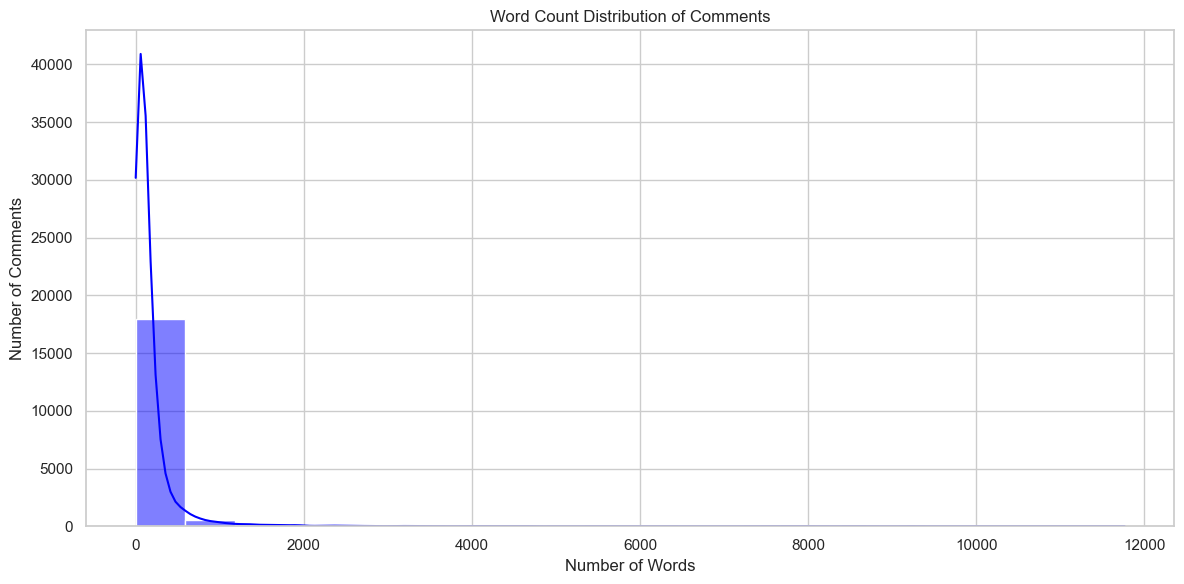

In [15]:
from utils.plot_words_distribution import plot_distribution_of_words

# define the column name of the text
text_col = 'comment'
label_col='label'

# plot the words distribution
plot_distribution_of_words(news_df, text_col)

In [20]:
from sklearn.model_selection import train_test_split
from langdetect import detect, DetectorFactory
from utils.load_pretrained_spacy_model import load_pretrained_model

x_train_news, x_test_news, y_train_news, y_test_news = train_test_split(
    news_df,
    news_df['label'],
    test_size=0.01,
    random_state=42,
    stratify=news_df['label']
)

# load the pretrained spacy model
x_test_news, nlp_pretrained_name = load_pretrained_model(df=x_test_news, text_col=text_col)

The language of the dataset is: en


### 1ST CLUSTERING TECHNIQUE: KMEANS

We are going to implement the original KMeans without using any constraints. For transforming the data we are going to use TF-IDF and FastText embeddings.

#### USING TF-IDF VECTORIZATION

C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\1. Python\LLM_mods_Topic_Modelling\venv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ca', 'nt'] not in stop_words.
  warnings.warn(


Sentences transformed successfully via TF-IDF vectorizer


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.82it/s]

The optimum kappa based on Silhouette score is: 35


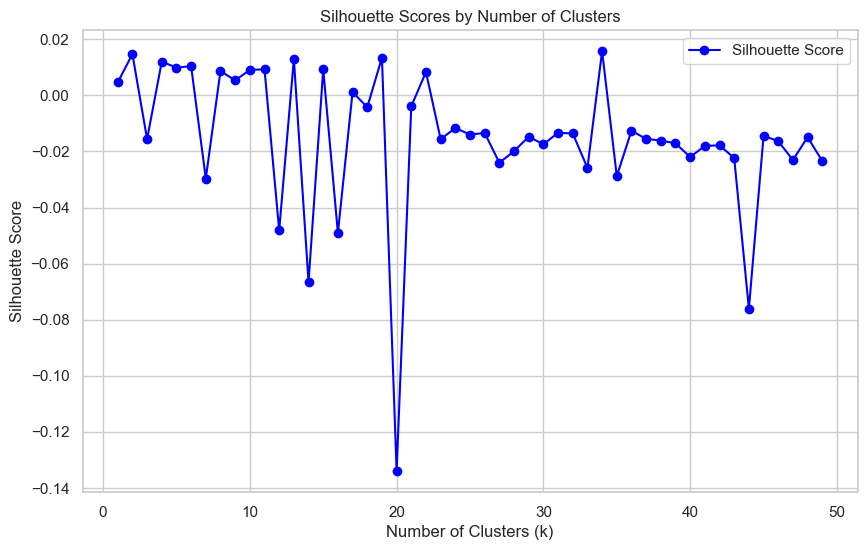

The NMI score is: 0.27912484204485805 for the best Kappa 35
The AMI score is: -0.0030960366950007535 for the best Kappa 35
The ARI score is: -0.0005811234996188307 for the best Kappa 35


In [23]:
import spacy
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import calc_tf_idf_vectors

# define the spacy model
nlp = spacy.load(nlp_pretrained_name)

# define the corpus
corpus = news_df[text_col].to_list()

# calc TF-IDF features
transformed_data_tfidf = calc_tf_idf_vectors(corpus, x_test_news[text_col], nlp)

max_num_of_clusters = 50

# calculate the optimun kappa with KMeans via Silhouette score and using TF-IDF
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_tfidf, max_num_of_clusters, true_labels=y_test_news)

#### USING FASTTEXT VECTORIZATION

Sentences transformed successfully via pretrained FastText language model


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.69it/s]


The optimum kappa based on Silhouette score is: 2


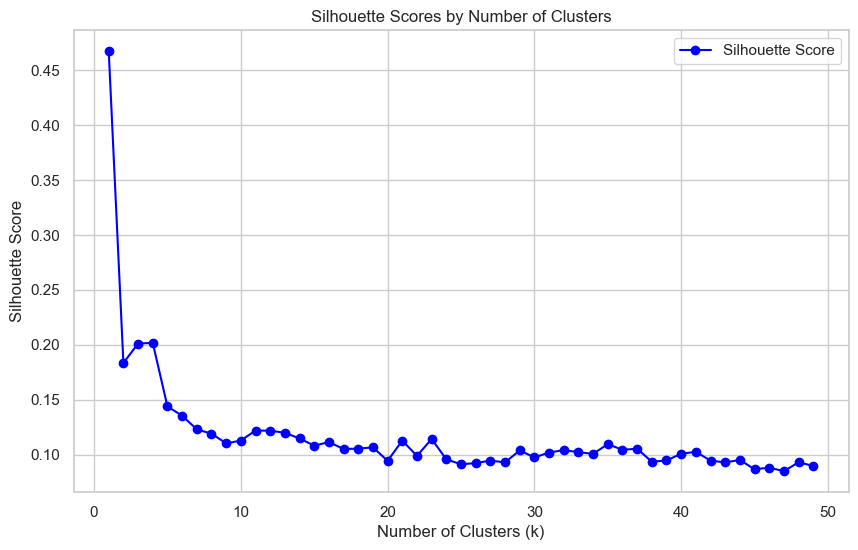

The NMI score is: 0.09056047912321492 for the best Kappa 2
The AMI score is: 0.03427815422641128 for the best Kappa 2
The ARI score is: 0.008669191972258794 for the best Kappa 2


In [25]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import train_fasttext_and_transform

# define the corpus
corpus = news_df[text_col].to_list()

transformed_data_fasttext = train_fasttext_and_transform(corpus, x_test_news[text_col].to_list(), text_col)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using FastText
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
    transformed_data_fasttext, max_num_of_clusters, true_labels=y_test_news)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

In [26]:
import torch
import gc

# Collect garbage to free memory
gc.collect()
# Clear GPU memory cache
torch.cuda.empty_cache()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.47it/s]


The optimum kappa based on Silhouette score is: 18


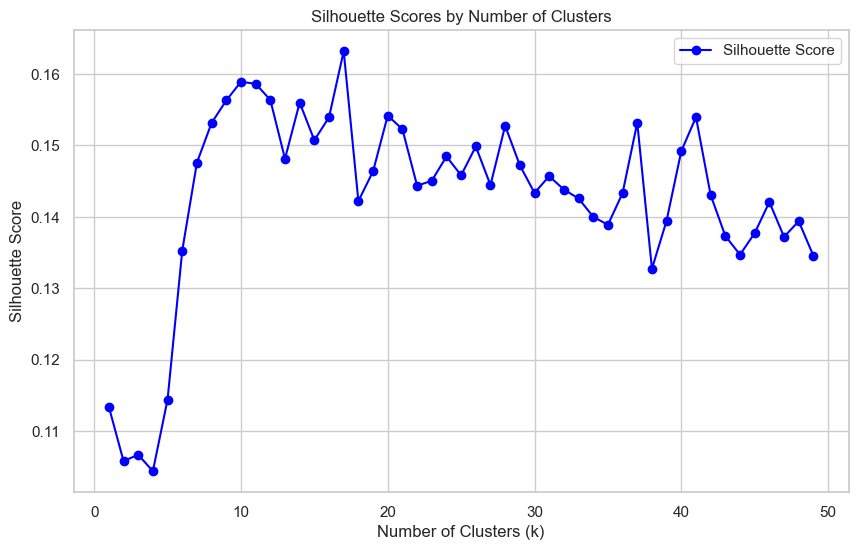

The NMI score is: 0.6067837768883493 for the best Kappa 18
The AMI score is: 0.42686447692923357 for the best Kappa 18
The ARI score is: 0.2849824461484294 for the best Kappa 18


In [33]:
# !pip install umap-learn
from clustering_algorithms.kmeans import calc_kmeans
from utils.text_to_embeddings import calc_embeddings
from sklearn.decomposition import PCA

# # transform the comments into embbeddings via sentence transformer
# transformed_data_embeddings = calc_embeddings(x_test_news[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=24)
reduced_data = pca.fit_transform(transformed_data_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_kmeans(
reduced_data, max_num_of_clusters, true_labels=y_test_news)

#### USING OPENAI ADA TEXT EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.83it/s]


The optimum kappa based on Silhouette score is: 17


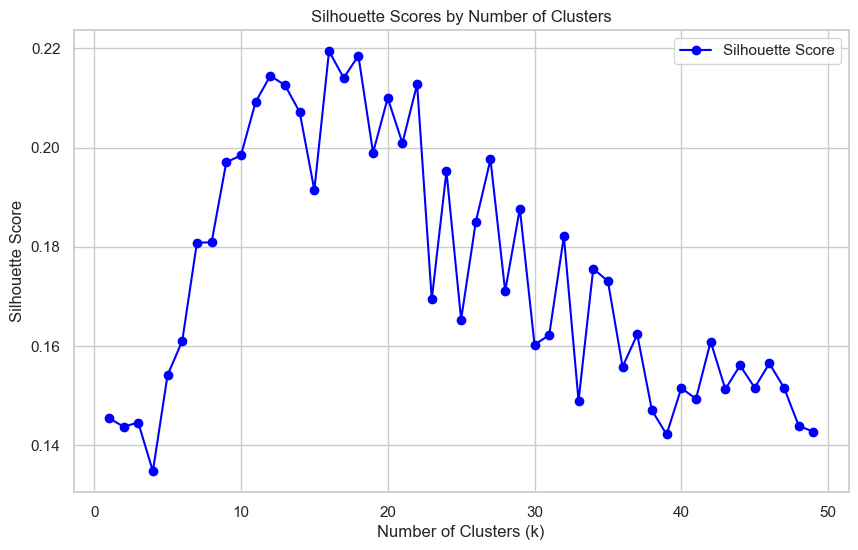

The NMI score is: 0.6156956764008961 for the best Kappa 17
The AMI score is: 0.4489891849252299 for the best Kappa 17
The ARI score is: 0.310436684783277 for the best Kappa 17


In [35]:
from clustering_algorithms.kmeans import calc_kmeans
from utils.GPT_Prompting import PromptingGPT
from sklearn.decomposition import PCA

# Create a new instance of GPT model in each iteration
gpt_embeddings = PromptingGPT()

# openai_ada_embeddings = gpt_embeddings.get_embeddings(texts=x_test_news[text_col], max_token_length=8000)

# Reduce the dimensionality of embeddings
pca = PCA(n_components=16) 
reduced_data = pca.fit_transform(openai_ada_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ada, scores_kmeans_ada, nmi_ada, ari_ada, ami_ada = calc_kmeans(
    reduced_data, max_num_of_clusters, true_labels=y_test_news)

### 2ND CLUSTERING TECHNIQUE: KMEANS CONSTRAINED (DEFINE MIN SIZE OF CLUSTERS)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
max_num_of_clusters = 20

# calculate the optimun kappa with KMeans Constrained via Silhouette score and using TF-IDF
kappa_kmeans_cv_silhouette_tfidf, scores_kmeans_cv_silhouette_tfidf = get_number_of_clusters_with_statistic_constrained(
   transformed_data_news_tfidf, max_num_of_clusters, statistic_metric='silhouette'
)

#### USE SILHOUETTE SCORE AS STATISTICS VALUE AND FASTTEXT VECTORIZATION

In [ ]:
# calculate the optimun kappa with KMeans Constrained via Silhouette score and using FastText
kappa_kmeans_cv_silhouette_ft, scores_kmeans_cv_silhouette_ft = get_number_of_clusters_with_statistic_constrained(
    transformed_data_news_fasttext, max_num_of_clusters, statistic_metric='silhouette'
)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:07<00:00,  6.81it/s]


The optimum kappa based on Penalized Silhouette score is: 3


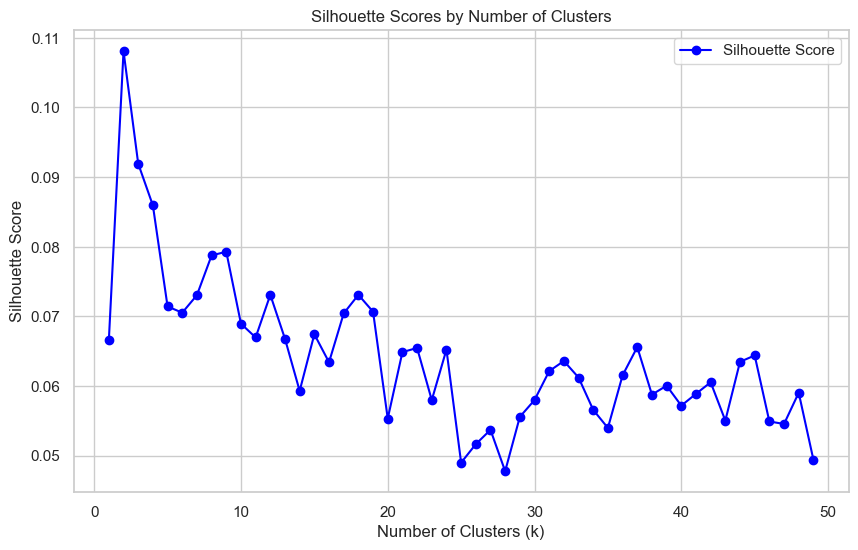

The best NMI score is: 0.7134037047480932 and the best Kappa: 40
The best AMI score is: 0.450054289657232 and the best Kappa: 10
The best ARI score is: 0.3041630417730365 and the best Kappa: 19


In [9]:
from clustering_algorithms.kmeans_constrained import get_number_of_clusters_with_statistic_constrained
from utils.calc_embeddings_via_transformer import calc_embeddings
from sklearn.decomposition import PCA

# # transform the comments into embbeddings via sentence transformer
# transformed_data_embeddings = calc_embeddings(x_test_news[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=32, svd_solver='auto')
reduced_data = pca.fit_transform(transformed_data_embeddings)

max_num_of_clusters = 50
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = get_number_of_clusters_with_statistic_constrained(
reduced_data, max_num_of_clusters, true_labels=y_test_news)


### 3RD CLUSTERING TECHNIQUE: AGGLOMERATIVE

#### USING TF-IDF VECTORIZATION

In [ ]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_tfidf, scores_agglomerative_tfidf = calc_agglomerative(transformed_data_news_tfidf, cluster_values)

#### USING FASTTEXT VECTORIZATION

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:22<00:00,  4.37it/s]

The optimal number of clusters based on Silhouette score is: 2


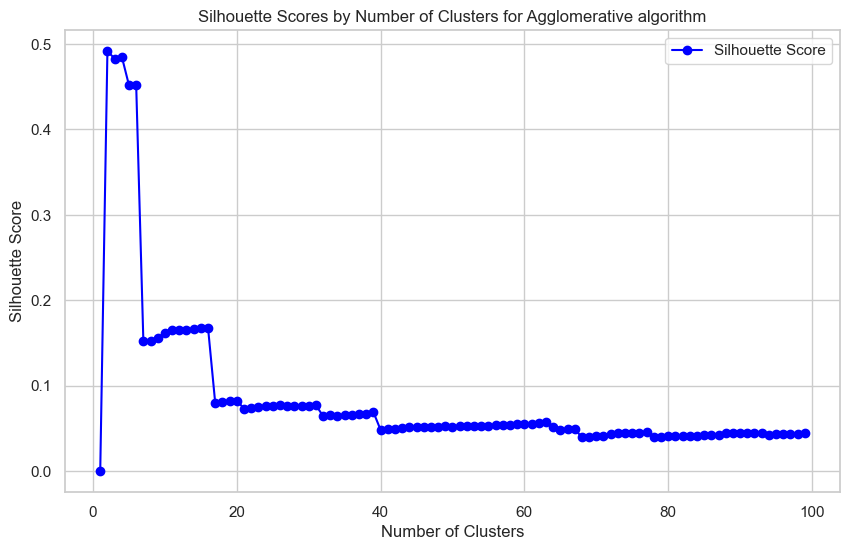

In [66]:
from clustering_algorithms.agglomerative import calc_agglomerative

cluster_values = range(1,100)

# calculate the optimun kappa with Agglomerative clustering algorithm via Silhouette score and using TF-IDF
kappa_agglomerative_ft, scores_agglomerative_ft = calc_agglomerative(transformed_data_news_fasttext, cluster_values)

#### USING SENTENCE TRANSFORMER EMBEDDINGS

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 188.43it/s]


The optimal number of clusters based on Silhouette score is: 45


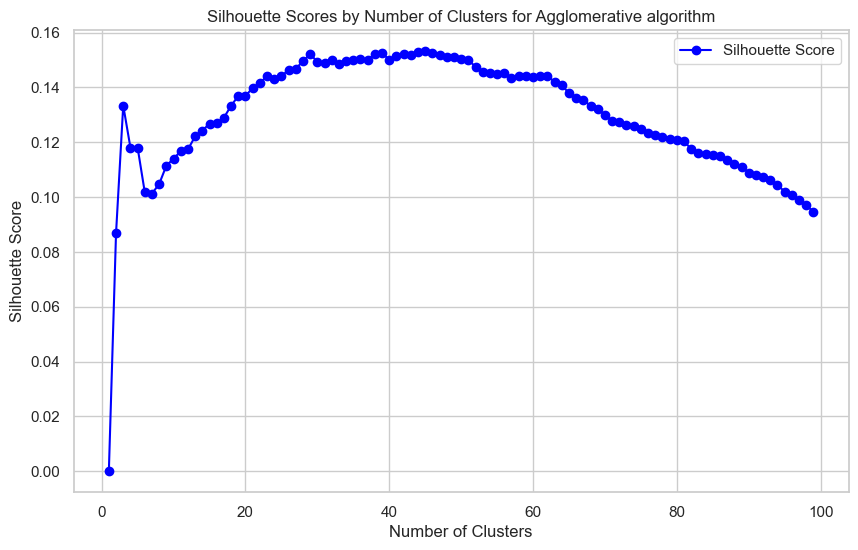

The best NMI score is: 0.7407931483001742 and the best Kappa: 98
The best AMI score is: 0.43522594764969436 and the best Kappa: 10
The best ARI score is: 0.2798561953734677 and the best Kappa: 28


In [7]:
from clustering_algorithms.agglomerative import calc_agglomerative
from utils.calc_embeddings_via_transformer import calc_embeddings
from sklearn.decomposition import PCA

# # transform the comments into embbeddings via sentence transformer
# transformed_data_embeddings = calc_embeddings(x_test_news[text_col].to_list())

# Reduce the dimensionality of embeddings
pca = PCA(n_components=32, svd_solver='auto')
reduced_data = pca.fit_transform(transformed_data_embeddings)

cluster_values = range(1,100)
# calculate the optimun kappa with KMeans via Silhouette score and using Embeddings from Transformer model
kappa_kmeans_ft, scores_kmeans_ft, statistic_values_nmi, statistic_values_ari, statistic_values_ami = calc_agglomerative(
reduced_data, cluster_values, true_labels=y_test_news)

### 4TH CLUSTERING TECHNIQUE: DBSCAN (DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

Suggested eps values:[1.08373218 1.08694555 1.09013128 1.09320133 1.09597954 1.09798219
 1.09988077 1.10251005 1.10374104 1.10696425 1.10890137 1.11110556
 1.1120914  1.11541039 1.11843946 1.12022754 1.1216928  1.12499048
 1.1261166  1.12747263 1.12897392 1.13115295 1.13284597 1.13431365
 1.13520177 1.13664201 1.13847858 1.14067411 1.14155211 1.14272161
 1.14488541 1.14593345 1.14753529 1.14858842 1.15061696 1.15203911
 1.15316719 1.1550506  1.15603603 1.15763365 1.15861427 1.15973323
 1.16077028 1.16149071 1.16212524 1.1630547  1.16384633 1.16511952
 1.16666447 1.16774075 1.16937763 1.17061241 1.17285566 1.17409188
 1.17499315 1.17555046 1.17649574 1.17771143 1.17943737 1.18129243
 1.18370825 1.18510797 1.18622311 1.18702908 1.18818643 1.18951829
 1.19116572 1.19203577 1.19265891 1.19372167 1.19559561 1.19641413
 1.19796246 1.19898807 1.20126307 1.20234631 1.20352532 1.20450335
 1.20578446 1.2075064  1.20930749 1.21008296 1.21130585 1.21237644
 1.21362685 1.21476246 1.21600752 1.21668

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]

The optimal eps based on Silhouette score is: 1.0837321846361068
The number of clusters for optimal eps is: 2


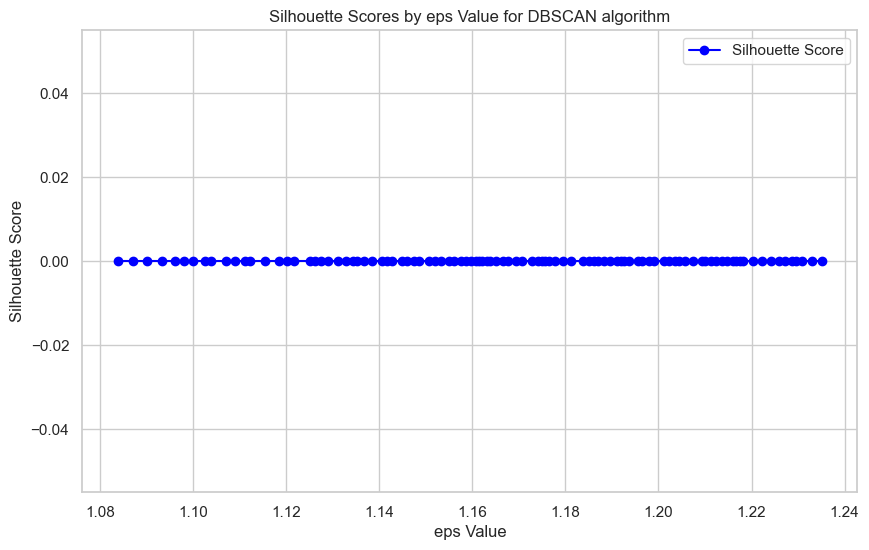

In [30]:
from clustering_algorithms.dbscan import generate_eps_values_via_nearest_neighbors, calc_dbscan

# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_tfidf, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_tfidf, kappa_dbscan_tfidf, scores_dbscan_tfidf = calc_dbscan(transformed_data_news_tfidf, eps_values)

#### USING FASTTEXT VECTORIZATION

Suggested eps values:[0.01674839 0.01685766 0.01709097 0.01715278 0.01736742 0.017478
 0.01760425 0.01766995 0.01776997 0.01789351 0.01799958 0.0181775
 0.01825249 0.01836836 0.01846593 0.01854909 0.01861766 0.0187883
 0.01884829 0.01901204 0.0191505  0.01926596 0.01938464 0.01944985
 0.01953625 0.01964393 0.0197191  0.01987686 0.01997298 0.02015237
 0.0202366  0.02037243 0.02044862 0.02056109 0.02067212 0.02082226
 0.02089162 0.02108775 0.0211949  0.0213111  0.0213928  0.02156386
 0.02167253 0.02177446 0.02189753 0.02207539 0.02226427 0.02238355
 0.02251322 0.02255815 0.02268564 0.02275752 0.02280506 0.02291024
 0.02300365 0.02307382 0.02320731 0.02327054 0.02343678 0.02352811
 0.02365736 0.02371284 0.02378293 0.02393082 0.02406294 0.02419991
 0.02433877 0.02438019 0.02455997 0.02472277 0.02483994 0.02491746
 0.02497936 0.025134   0.02526493 0.02539545 0.02550696 0.02558245
 0.02567343 0.02585809 0.02605435 0.02627814 0.02648001 0.02668546
 0.02686302 0.02706829 0.02733127 0.02740799 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.52it/s]


The optimal eps based on Silhouette score is: 0.016748389415442943
The number of clusters for optimal eps is: 1


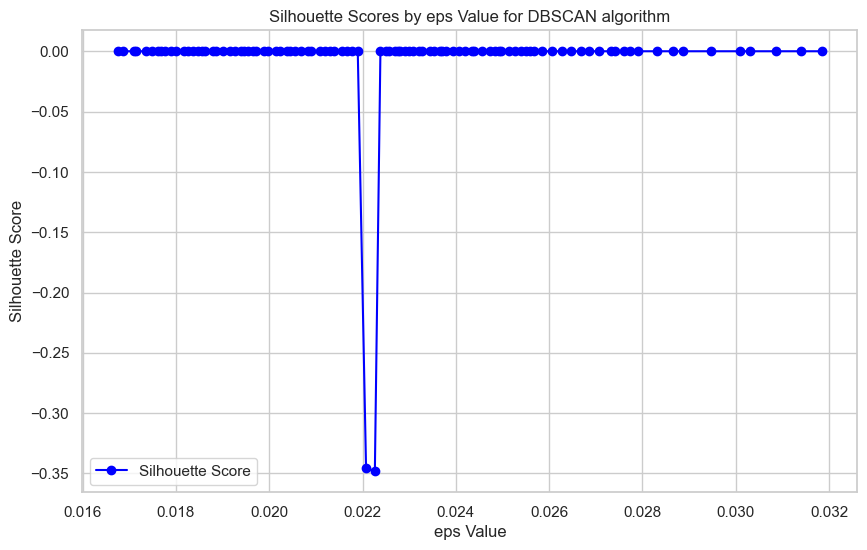

In [31]:
# Generate the best eps values based on the distance of the dataset
eps_values = generate_eps_values_via_nearest_neighbors(transformed_data_fasttext, num_values=100)

# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using FastText
optimal_eps_ft, kappa_dbscan_ft, scores_dbscan_ft = calc_dbscan(transformed_data_news_fasttext, eps_values)

### 5TH CLUSTERING TECHNIQUE: HDBSCAN (HIERARCHICAL DENSITY-BASED CLUSTERING NON-PARAMETRIC ALGORITHM)

#### USING TF-IDF VECTORIZATION

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 203.08it/s]


The optimal min_cluster_size based on Silhouette score is: 45
The number of clusters for optimal min_cluster_size is: 3


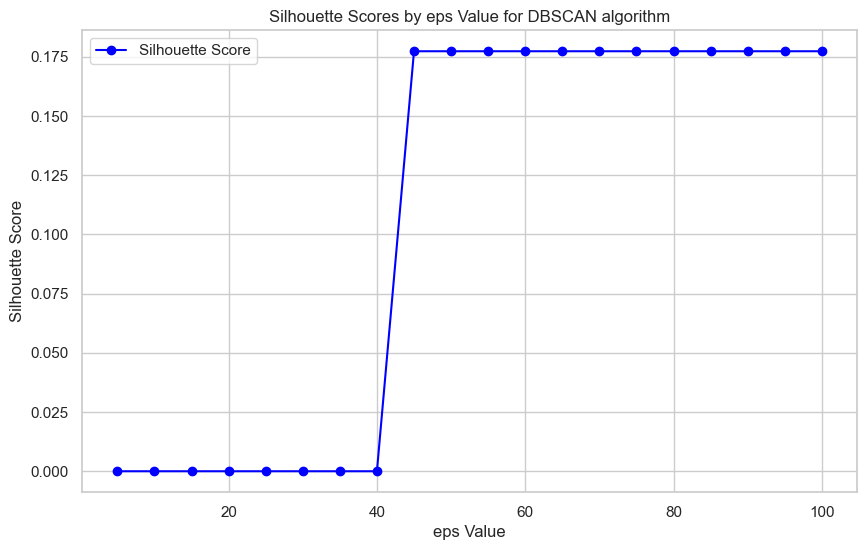

In [22]:
from clustering_algorithms.hdbscan import calc_hdbscan

maximum_cluster_size_values = [i for i in range(5, 105, 5)]
# calculate the optimun kappa with DBSCAN clustering algorithm via Silhouette score and using TF-IDF
optimal_eps_hdbscan_tfidf, kappa_hdbscan_tfidf, scores_hdbscan_tfidf = calc_hdbscan(reduced_data, maximum_cluster_size_values)